<a href="https://colab.research.google.com/github/aderdouri/PINNs/blob/master/Training/Navier_Stokes_deepxde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deepxde

In [ ]:
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

In [3]:
rho = 1
mu = 1
u_in = 1
D = 1
L = 2

In [4]:
geom = dde.geometry.Rectangle(xmin=[-L/2, -D/2], xmax=[L/2, D/2])

In [5]:
def boundary_wall(X, on_boundary):
    print("X",X)
    print("on_boundary",on_boundary)
    on_wall = np.logical_and(np.logical_or(np.isclose(X[1],-D/2,rtol=1e-05,atol=1e-08),np.isclose(X[1],D/2,rtol=1e-05,atol=1e-08)),on_boundary)
    return on_wall

def boundary_inlet(X,on_boundary):
    on_inlet = np.logical_and(np.isclose(X[0],-L/2,rtol=1e-05,atol=1e-08),on_boundary)
    return on_inlet

def boundary_outlet(X,on_boundary):
    on_outlet = np.logical_and(np.isclose(X[0],L/2,rtol=1e-05,atol=1e-08),on_boundary)
    return on_outlet

In [6]:
bc_wall_u = dde.DirichletBC(geom, lambda X:0., boundary_wall, component= 0)
bc_wall_v = dde.DirichletBC(geom, lambda X:0., boundary_wall, component= 1)

bc_inlet_u = dde.DirichletBC(geom, lambda X:u_in, boundary_inlet, component= 0)
bc_inlet_v = dde.DirichletBC(geom, lambda X:0.   , boundary_inlet, component= 1)

bc_outlet_p = dde.DirichletBC(geom, lambda X:0.  , boundary_outlet, component= 2)
bc_outlet_v = dde.DirichletBC(geom, lambda X:0.  , boundary_outlet, component= 1)

In [7]:
def pde(X,Y):
    du_x =dde.grad.jacobian(Y, X, i=0, j=0)
    du_y =dde.grad.jacobian(Y, X, i=0, j=1)
    dv_x =dde.grad.jacobian(Y, X, i=1, j=0)
    dv_y =dde.grad.jacobian(Y, X, i=1, j=1)
    dp_x =dde.grad.jacobian(Y, X, i=2, j=0)
    dp_y =dde.grad.jacobian(Y, X, i=2, j=1)

    du_xx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(Y, X, component=1, i=1, j=1)

    pde_u    = Y[:,0:1]*du_x +  Y[:,1:2]*du_y + 1/rho * dp_x - (mu/rho) * (du_xx+ du_yy)
    pde_v    = Y[:,0:1]*dv_x +  Y[:,1:2]*dv_y + 1/rho * dp_y - (mu/rho) * (dv_xx+ dv_yy)
    pde_cont = du_x + dv_y

    return [pde_u,pde_v,pde_cont]

In [ ]:
data = dde.data.PDE(geom,
                   pde,
                   [bc_wall_u,bc_wall_v,bc_inlet_u,bc_inlet_v,bc_outlet_p,bc_outlet_v],
                   num_domain  = 2000,
                   num_boundary= 200,
                   num_test = 200)

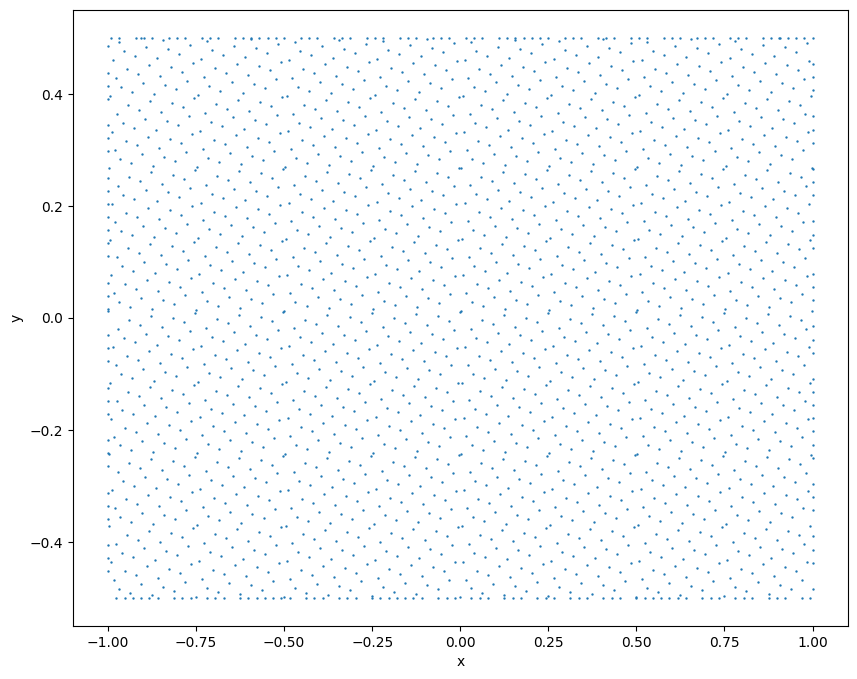

In [9]:
plt.figure(figsize=(10,8))
plt.scatter(data.train_x_all[:,0], data.train_x_all[:,1], s= 0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [10]:
net = dde.maps.FNN([2] + [64]*5 + [3] , "tanh", "Glorot uniform")

In [11]:
model = dde.Model(data, net)
model.compile("adam",lr=1e-3)

Compiling model...
Building feed-forward neural network...
'build' took 0.132344 s

'compile' took 2.102980 s



In [12]:
losshistory, train_state = model.train(epochs = 10000)

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.95e-02, 1.87e-01, 2.20e-02, 2.17e-02, 1.59e-02, 1.21e+00, 4.01e-02, 2.51e-02, 4.04e-02]    [1.84e-02, 1.92e-01, 2.20e-02, 2.17e-02, 1.59e-02, 1.21e+00, 4.01e-02, 2.51e-02, 4.04e-02]    []  
1000      [1.03e-03, 6.28e-04, 9.55e-03, 2.94e-02, 1.55e-02, 3.86e-02, 2.82e-03, 4.76e-04, 2.09e-05]    [5.99e-04, 2.83e-04, 5.47e-03, 2.94e-02, 1.55e-02, 3.86e-02, 2.82e-03, 4.76e-04, 2.09e-05]    []  
2000      [9.62e-04, 5.45e-04, 4.24e-03, 2.19e-02, 1.18e-02, 3.30e-02, 5.23e-04, 1.58e-04, 3.31e-05]    [4.37e-04, 3.19e-04, 2.49e-03, 2.19e-02, 1.18e-02, 3.30e-02, 5.23e-04, 1.58e-04, 3.31e-05]    []  
3000      [8.44e-04, 5.02e-04, 3.18e-03, 1.91e-02, 9.97e-03, 2.64e-02, 1.34e-03, 4.41e-05, 7.44e-06]    [4.24e-04, 2.84e-04, 1.63e-03, 1.91e-02, 9.97e-03, 2.64e-0

In [13]:
dde.optimizers.config.set_LBFGS_options(maxiter= 3000)
model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=False, isplot=False)

Compiling model...
'compile' took 1.833756 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
10000     [9.51e-04, 6.46e-04, 2.36e-03, 1.49e-02, 5.94e-03, 1.53e-02, 5.11e-03, 2.31e-03, 9.61e-06]    [8.31e-04, 4.63e-04, 8.75e-04, 1.49e-02, 5.94e-03, 1.53e-02, 5.11e-03, 2.31e-03, 9.61e-06]    []  
10019     [9.51e-04, 6.46e-04, 2.36e-03, 1.49e-02, 5.94e-03, 1.53e-02, 5.11e-03, 2.31e-03, 9.61e-06]    [8.31e-04, 4.63e-04, 8.75e-04, 1.49e-02, 5.94e-03, 1.53e-02, 5.11e-03, 2.31e-03, 9.61e-06]    []  

Best model at step 8000:
  train loss: 4.57e-02
  test loss: 4.39e-02
  test metric: []

'train' took 4.971939 s



In [14]:
samples = geom.random_points(500000)
result = model.predict(samples)

In [ ]:
color_legend = [[0,1.5],[-0.3,0.3],[0,35]]

for idx in range(3):
    plt.figure(figsize=(20,4))
    plt.scatter(samples[:,0],
               samples[:,1],
               c = result[:,idx],
               cmap= 'jet',
               s=2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((0-L/2, L-L/2))
    plt.ylim((0-D/2, D-D/2))
    plt.tight_layout()
    plt.show()